
# Project: Investigate The Movie Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

__The Movie Database (TMDb)__ is a popular, user editable database for movies and TV shows. The data set provided contains information about 10,000 movies collected from TMDb, including features such as user ratings and revenue.

First, we can focus on the top 10 for multiples categories :
- What are the 10 most popular movies ?
- Which 10 films had the biggest budget?
- Which 10 films had the highest revenue?
- Which actors did the most amount of movies (in this database) ?
- What are the 10 most used genres?

Then we can focus on the evolution of multiple categories through the years:
- How does popularity evolve over the years?
- How does budget evolve over the years?
- How does revenue evolve over the years?
- Who are the most busy actors each year?
- How does the most used genres evolve over the years?

Finally, we can ask ourselves :
- What are some characteristics of profitable movies ? (average budget, month of release, average runtime, vote_average)

In [1]:
# import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime

In [2]:
# help functions

def barh_chart_invert(locations, heights, labels, title, xlabel):
    plt.barh(locations, heights, tick_label=labels)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel(xlabel);
    
def plot_year(x, y, title, xlabel, ylabel):
    plt.plot(x, y, 'y-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);
    
def split_cell(df, old_column, new_column, delimiter):
    return df[old_column] \
            .apply(lambda x: x.split(delimiter)) \
            .apply(pd.Series) \
            .merge(df, left_index = True, right_index = True) \
            .drop([old_column], axis=1) \
            .melt(id_vars=tmp_columns, value_name=new_column) \
            .drop('variable', axis=1) \
            .dropna(subset=[new_column])

<a id='wrangling'></a>
## Data Wrangling


### General Properties

Let's start by loading and looking at what the dataset looks like.

In [3]:
# load and display data
df = pd.read_csv('tmdb-movies.csv')
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


The data set contains 21 columns. To answer the above questions, we will keep the following column : *popularity*, *budget*, *revenue*, *original_title*, *cast*, *runtime*, *genres*, *release_date* and *vote_average*. We will also keep the *id* column to assure the unicity of the rows. We will drop the others.

At first glance, the data seems correct, except for some columns such as *cast* and *genres* that are strings containing multiple values separated by '|' and the *release_date* that is a string instead of a datetime object. As we will use these ones in our analysis, we will have to handle them later.

Let's take a closer look :

In [4]:
# general informations : format, number of rows, null values...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [5]:
# missing values
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [6]:
# duplicated rows
sum(df.duplicated())

1

There are a total of 10866 entries, includind one duplicated row. In the columns we are interested in, there are 76 missing values in the *cast* column and 23 missing values in the *genres* column. We will need to drop the lines with missing values and the duplicated line.

Now let's analyse the values :

In [7]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [8]:
df.query('budget == 0')['budget'].count(), df.query('revenue == 0')['revenue'].count(), df.query('runtime == 0')['runtime'].count()

(5696, 6016, 31)

Here we notice that there are a lot of zero in the columns *budget*, *revenue* and *runtime*. As these values are more likely to be missing data than actual data, it could wrongly influence our future analysis. To avoid that, the lines containing such values will be handled.



### Data Cleaning

Let's start by removing the duplicated line.

In [9]:
# duplicated rows
df_dropped = df.drop_duplicates()

And then we drop the columns we don't need.

In [10]:
# drop columns
df_dropped = df[['id', 'original_title', 'budget', 'revenue', 'cast', 'genres', 'release_date', 'runtime', 'popularity', 'vote_average']].copy()
df_dropped.head(1)

,id,original_title,budget,revenue,cast,genres,release_date,runtime,popularity,vote_average
0,135397,Jurassic World,150000000,1513528810,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Action|Adventure|Science Fiction|Thriller,6/9/15,124,32.985763,6.5


Now we drop the lines with wissing values.

In [11]:
df_dropped.dropna(inplace=True)

We also would like to drop all the lines where the columns *budget*, *revenue* and *runtime* are equal to zero. But let's see how many rows that would be :

In [12]:
# budget
df_dropped.query('budget == 0')['id'].count()

5610

In [13]:
# revenue
df_dropped.query('revenue == 0')['id'].count()

5923

In [14]:
# runtime
df_dropped.query('runtime == 0')['id'].count()

30

With the *budget* and *revenue* columns, more than half of the dataset would be dropped, we would be losing too much data. However we can't keep them in the data set like that as it could affect our future analysis. We decide to replace these zeros with null values. Concerning the *runtime* column, the number of rows with zeros is small enough to be dropped.

Let's do this :

In [15]:
# budget
df_dropped['budget'].replace(0, np.NaN, inplace=True)

# revenue
df_dropped['revenue'].replace(0, np.NaN, inplace=True)

# runtime
df_dropped.query('runtime != 0', inplace=True)

Now we need to convert the *release_date* column from string to datetime.

In [16]:
def set_date(date):
    dt = datetime.strptime(date, '%m/%d/%y')
    if dt.year > 2050:
        dt = dt.replace(year = dt.year - 100)
    return dt
     

df_dropped['release_date'] = df_dropped['release_date'].apply(lambda x: set_date(x))

Finally, we need to take care of the *cast* and *genres* columns : the value of each cell is a strings containing multiple values separated by '|' and we want to split them in multiple rows. We will do that work in separate dataframes, that we will use when needed in order to answer the questions.

In [17]:
# cast column
tmp_columns = list(df_dropped.columns.values)
del tmp_columns[4]

df_cast_splitted = split_cell(df_dropped, 'cast', 'actor', '|')

df_cast_splitted.head(2)

,id,original_title,budget,revenue,genres,release_date,runtime,popularity,vote_average,actor
0,135397,Jurassic World,150000000.0,1.513529e+09,Action|Adventure|Science Fiction|Thriller,2015-06-09,124,32.985763,6.5,Chris Pratt
1,76341,Mad Max: Fury Road,150000000.0,3.784364e+08,Action|Adventure|Science Fiction|Thriller,2015-05-13,120,28.419936,7.1,Tom Hardy


In [18]:
# genres column
tmp_columns = list(df_dropped.columns.values)
del tmp_columns[5]

df_genres_splitted = split_cell(df_dropped, 'genres', 'genre', '|')

df_genres_splitted.head(2)

,id,original_title,budget,revenue,cast,release_date,runtime,popularity,vote_average,genre
0,135397,Jurassic World,150000000.0,1.513529e+09,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,2015-06-09,124,32.985763,6.5,Action
1,76341,Mad Max: Fury Road,150000000.0,3.784364e+08,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,2015-05-13,120,28.419936,7.1,Action


Now our data is cleaned, let's start the EDA phase.

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 : Top 10

Here we will focus on the top 10 for multiples categories :
- What are the 10 most popular movies right now?
- Which 10 films had the biggest budget?
- Which 10 films had the highest revenue?
- Which actors did the most amount of movies (in this database) ?
- What are the 10 most used genres?

#### What are the 10 most popular movies right now?

Popularity is a very important metric on TMDb. The popularity value is based on the number of votes for the day, the number of views for the day, the number of users who marked it as a "favourite" for the day, the number of users who added it to their "watchlist" for the day, the release_date, the number of total votes and the previous days score.

In [19]:
res = df_dropped.sort_values(by='popularity', ascending=False)[['id', 'original_title', 'popularity']].head(10)
res

,id,original_title,popularity
0,135397,Jurassic World,32.985763
1,76341,Mad Max: Fury Road,28.419936
629,157336,Interstellar,24.949134
630,118340,Guardians of the Galaxy,14.311205
2,262500,Insurgent,13.112507
631,100402,Captain America: The Winter Soldier,12.971027
1329,11,Star Wars,12.037933
632,245891,John Wick,11.422751
3,140607,Star Wars: The Force Awakens,11.173104
633,131631,The Hunger Games: Mockingjay - Part 1,10.739009


The most popular film at the moment is Jurassic World with a score of 32.985763, followed by Mad Max: Fury Road with a score of 28.419936 and Interstellar with a score of 24.949134. The top 10 most popular movies at the moment ends with The Hunger Games: Mockingjay - Part 1 with a score of 10.739009.

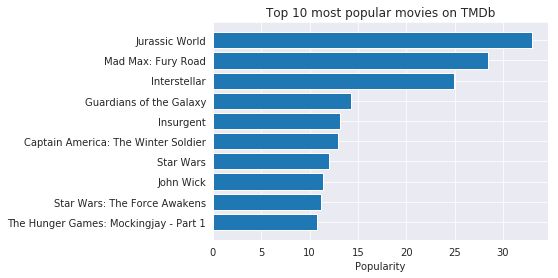

In [20]:
locations = list(range(10))
heights = res['popularity']

barh_chart_invert(locations, heights, res['original_title'], 'Top 10 most popular movies on TMDb', 'Popularity')

#### Which 10 films had the biggest budget?

In [21]:
res = df_dropped.sort_values(by='budget', ascending=False)[['id', 'original_title', 'budget']].head(10)
res

,id,original_title,budget
2244,46528,The Warrior's Way,425000000.0
3375,1865,Pirates of the Caribbean: On Stranger Tides,380000000.0
7387,285,Pirates of the Caribbean: At World's End,300000000.0
14,99861,Avengers: Age of Ultron,280000000.0
6570,1452,Superman Returns,270000000.0
1929,38757,Tangled,260000000.0
4411,49529,John Carter,260000000.0
7394,559,Spider-Man 3,258000000.0
5508,57201,The Lone Ranger,255000000.0
5431,57158,The Hobbit: The Desolation of Smaug,250000000.0


The film which had the biggest budget was The Warrior's Way with a budget of 425,000,000, followed by Pirates of the Caribbean: On Stranger Tides with a budget of 380,000,000 and Pirates of the Caribbean: At World's End with a budget of 300,000,000. The top 10 films which had the biggest budget ends with The Hobbit: The Desolation of Smaug with a budget of 250,000,000.

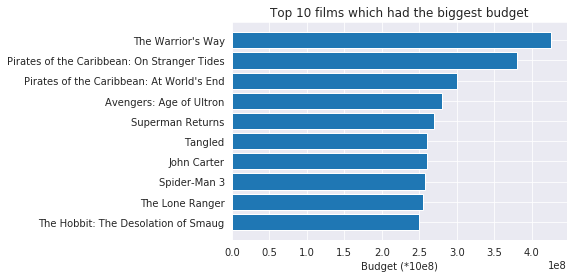

In [22]:
locations = list(range(10))
heights = res['budget']

barh_chart_invert(locations, heights, res['original_title'], 'Top 10 films which had the biggest budget', 'Budget (*10e8)')

#### Which 10 films had the highest revenue?

In [23]:
res = df_dropped.sort_values(by='revenue', ascending=False)[['id', 'original_title', 'revenue']].head(10)
res

,id,original_title,revenue
1386,19995,Avatar,2.781506e+09
3,140607,Star Wars: The Force Awakens,2.068178e+09
5231,597,Titanic,1.845034e+09
4361,24428,The Avengers,1.519558e+09
0,135397,Jurassic World,1.513529e+09
4,168259,Furious 7,1.506249e+09
14,99861,Avengers: Age of Ultron,1.405036e+09
3374,12445,Harry Potter and the Deathly Hallows: Part 2,1.327818e+09
5422,109445,Frozen,1.274219e+09
5425,68721,Iron Man 3,1.215440e+09


The film which had the highest revenue was Avatar with a revenue of 2,781,506,000, followed by Star Wars: The Force Awakens with a revenue of 2,068,178,000 and Titanic with a revenue of 1,845,034,000. The top 10 films which had the highest revenue ends with Iron Man 3 with a budget of 1,215,440,000.

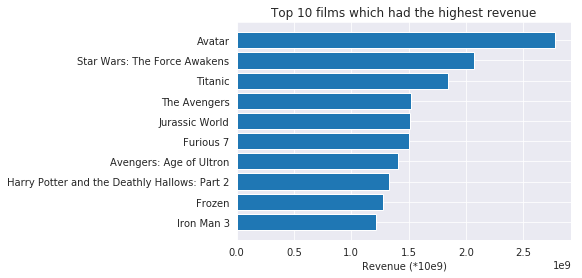

In [24]:
locations = list(range(10))
heights = res['revenue']

barh_chart_invert(locations, heights, res['original_title'], 'Top 10 films which had the highest revenue', 'Revenue (*10e9)')

#### Which actors did the most amount of movies (in this database) ?

In [25]:
res = df_cast_splitted.groupby(['actor'], as_index=False)['id'].count().sort_values(by='id', ascending=False).head(10)
res = res.rename(columns={'id':'total_movies'})
res

,actor,total_movies
15259,Robert De Niro,72
15995,Samuel L. Jackson,71
2496,Bruce Willis,62
13550,Nicolas Cage,61
12519,Michael Caine,53
15438,Robin Williams,51
8903,John Cusack,50
13127,Morgan Freeman,49
8944,John Goodman,49
10965,Liam Neeson,48


The actor with the most amount of movies is Robert De Niro with 72 movies, followed by Samuel L. Jackson with 71 movies and Bruce Willis with 62 movies. The top 10 actors with the most amount of movies ends with Liam Neeson with 48 movies.

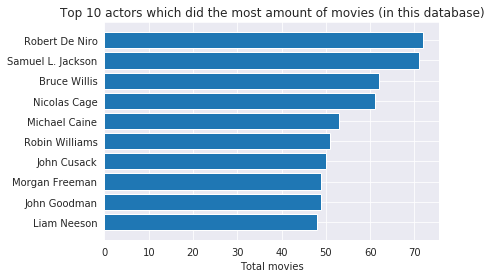

In [26]:
locations = list(range(10))
heights = res['total_movies']

barh_chart_invert(locations, heights, res['actor'], 'Top 10 actors which did the most amount of movies (in this database)', 'Total movies')

#### What are the 10 most used genres?

In [27]:
res = df_genres_splitted.groupby(['genre'], as_index=False)['id'].count().sort_values(by='id', ascending=False).head(10)
res = res.rename(columns={'id':'total_used'})
res

,genre,total_used
6,Drama,4744
3,Comedy,3774
17,Thriller,2904
0,Action,2380
14,Romance,1705
11,Horror,1629
1,Adventure,1468
4,Crime,1354
15,Science Fiction,1227
7,Family,1217


The genre the most used is *Drama* with 4744 uses, followed by *Comedy* with 3774 uses and *Thriller* with 2904 uses. The top 10 most used genres ends with *Family* with 1217 uses.

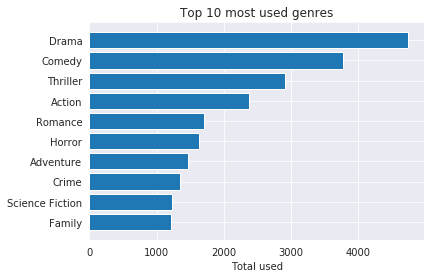

In [28]:
locations = list(range(10))
heights = res['total_used']

barh_chart_invert(locations, heights, res['genre'], 'Top 10 most used genres', 'Total used')

A bar chart is great, but a pie chart could be better to show these results. Let's make one.

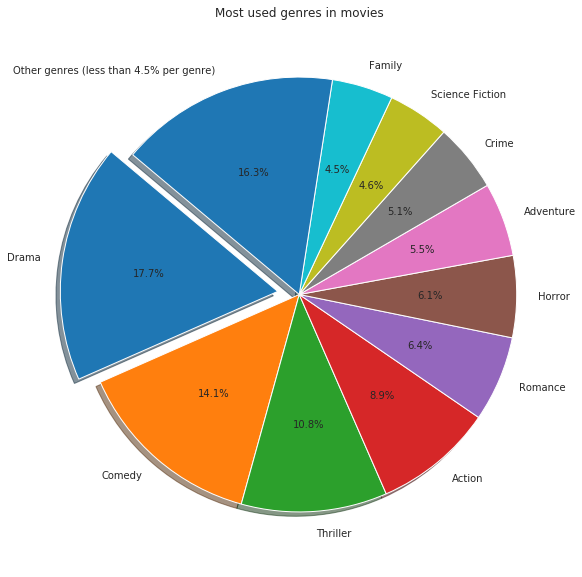

In [29]:
# compute the number of occurrences of the other genres
top_10_total_genre_occurence = res['total_used'].sum()
total_genre_occurence = df_genres_splitted.groupby(['genre'], as_index=False).count()['id'].sum()
other_total_genre_occurence = total_genre_occurence - top_10_total_genre_occurence

# pie
locations = list(range(11))
heights = res['total_used'].append(pd.Series([other_total_genre_occurence]))
labels = res['genre'].append(pd.Series(['Other genres (less than 4.5% per genre)']))
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

plt.figure(figsize=(20,10)) 
plt.pie(heights, labels=labels, explode=explode, shadow=True, startangle=140, autopct='%1.1f%%');
plt.title('Most used genres in movies');

### Research Question 2 :  Evolution through the years

Here we will focus on the evolution of multiple categories through the years:
- How does popularity evolve over the years?
- How does the budget evolve over the years?
- How does the revenue evolve over the years?
- Who are the most busy actors each year?
- How does the most used genres evolve over the years?

#### How does popularity evolve over the years?

For each year, we calculate the average *popularity* of all the films released this year, then we plot it to see the evolution of the *popularity* through the years. We chose the mean as it represents better the evolution of *popularity*.

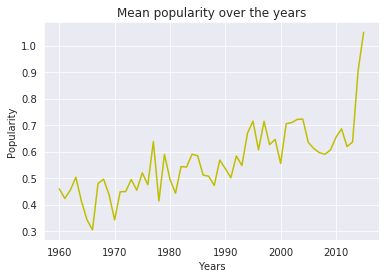

In [30]:
res = df_dropped.groupby(df_dropped['release_date'].map(lambda x: x.year), as_index=True).describe()['popularity']
plot_year(res.index, res['mean'], 'Mean popularity over the years', 'Years', 'Popularity')

Looking at the results, we can see that the most recent films are generally the most popular. This statement is especially true for the films released in the current year. That seems normal as recent films are more likely to be advertised. 

#### How does the budget evolve over the years?

For each year, we calculate the average *budget* of all the films released this year, then we plot it to see the evolution of the *budget* through the years. We chose the mean as it represents better the evolution of *budget*.

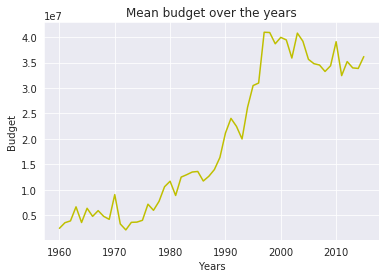

In [31]:
res = df_dropped.groupby(df_dropped['release_date'].map(lambda x: x.year), as_index=True).describe()['budget']
plot_year(res.index, res['mean'], 'Mean budget over the years', 'Years', 'Budget')

Looking at the result, we can see that the budget allocated to films increased over the years until the late 1990s, the began to stagnate and decrease slowly from then on.

#### How does the revenue evolve over the years?

For each year, we calculate the average *revenue* of all the films released this year, then we plot it to see the evolution of the *revenue* through the years. We chose the mean as it represents better the evolution of *revenue*.

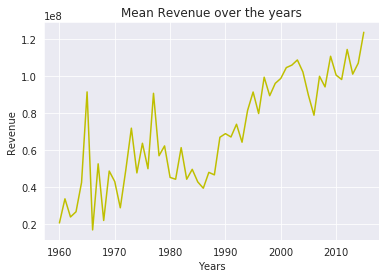

In [32]:
res = df_dropped.groupby(df_dropped['release_date'].map(lambda x: x.year), as_index=True).describe()['revenue']
plot_year(res.index, res['mean'], 'Mean Revenue over the years', 'Years', 'Revenue')

From what we saw previously with the *budget* evolution through the years, we can think that a bigger budget can lead to a bigger revenue.

#### Who are the most busy actors each year?

For each year, we find the actor who has been in the most films released this year.

In [33]:
res = df_cast_splitted.groupby([df_cast_splitted['release_date'].map(lambda x: x.year)], as_index=True)['actor'].apply(lambda x: x.value_counts().head(1))
res

release_date                      
1960          Jean Simmons             3
1961          Richard Widmark          2
1962          Karl Malden              2
1963          Flora Robson             2
1964          Vincent Price            3
1965          Michael Anderson Jr.     3
1966          Michael Caine            3
1967          Sidney Poitier           3
1968          Clint Eastwood           3
1969          Kenneth Williams         2
1970          Christopher Lee          4
1971          Clint Eastwood           3
1972          Peter Cushing            4
1973          Mitchell Ryan            3
1974          Gene Wilder              2
1975          Ed Lauter                2
1976          Jodie Foster             4
1977          Michael Ansara           2
1978          John Hurt                3
1979          Jack Warden              3
1980          Jamie Lee Curtis         3
1981          John Belushi             2
1982          Jeff Bridges             2
1983          Fred War

We notice that James Franco was pretty busy between around 2013-2015, with at least 16 movies! However, apart from a list of actors, we do not have much to learn from these results. It would be interesting to have more demographic data, such as gender or age, in order to get more interesting insights about our data.

#### How does the most used genres evolve over the years?

For each year, we find the genre for which there were the most amount of movies made this year.

In [34]:
res = df_genres_splitted.groupby([df_genres_splitted['release_date'].map(lambda x: x.year)], as_index=True)['genre'].apply(lambda x: x.value_counts().head(1))
res

release_date        
1960          Drama      13
1961          Drama      16
1962          Drama      21
1963          Drama      13
1964          Drama      20
1965          Drama      20
1966          Drama      16
1967          Comedy     17
1968          Drama      19
1969          Drama      13
1970          Drama      19
1971          Drama      30
1972          Drama      16
1973          Drama      31
1974          Drama      21
1975          Drama      17
1976          Drama      22
1977          Drama      23
1978          Drama      29
1979          Drama      30
1980          Drama      32
1981          Drama      32
1982          Drama      33
1983          Drama      35
1984          Drama      40
1985          Comedy     51
1986          Drama      51
1987          Comedy     57
1988          Comedy     69
1989          Comedy     63
1990          Drama      60
1991          Drama      63
1992          Drama      65
1993          Drama      90
1994          Comedy     88

It seems that we only have *Drama* and *Comedy*.

In [35]:
df_value_counts = pd.DataFrame(res)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['year', 'genre', 'total']
df_value_counts['genre'].value_counts()

Drama     48
Comedy     8
Name: genre, dtype: int64

In question 1, we determined that the most commonly used genre over the past 55 years was *drama*, followed by *comedy*. But as we see here with our results, the *drama* genre was not the most used genre every year! Yes, it is mainly this genre over the years but there are some exceptions.

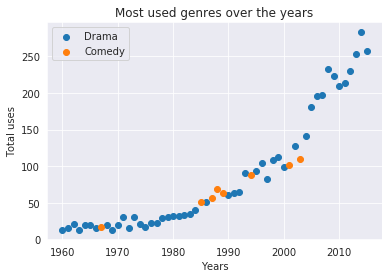

In [36]:
df_drama = df_value_counts.query('genre == "Drama"')
df_comedy = df_value_counts.query('genre == "Comedy"')

plt.scatter(df_drama['year'], df_drama['total'], label='Drama')
plt.scatter(df_comedy['year'], df_comedy['total'], label='Comedy')
plt.title('Most used genres over the years')
plt.xlabel('Years')
plt.ylabel('Total uses')
plt.legend();

This scatter plot shows that over the years, the most used genres are increasingly used in movies.

### Research Question 3 :  Characteristics of profitable movies

What are the characteristics of profitable movies ? We will try to answer this question with regard to the average budget, the month of release, the average runtime of movies and vote_average.

#### Top revenue sub-data set

First, we create a subset of data containing only the films that had the most revenue. This corresponds to films whose revenues are higher than 75% of other films.

In [37]:
df_dropped.describe()

,id,budget,revenue,runtime,popularity,vote_average
count,10738.000000,5.155000e+03,4.845000e+03,10738.000000,10738.000000,10738.000000
mean,65159.998137,3.082236e+07,8.930540e+07,102.698547,0.652207,5.968765
std,91375.257233,3.892661e+07,1.621300e+08,30.469401,1.004469,0.931295
min,5.000000,1.000000e+00,2.000000e+00,3.000000,0.000065,1.500000
25%,10549.250000,6.000000e+06,7.770731e+06,90.000000,0.210699,5.400000
50%,20350.000000,1.750000e+07,3.189900e+07,99.000000,0.387009,6.000000
75%,73935.750000,4.000000e+07,1.000000e+08,112.000000,0.720156,6.600000
max,417859.000000,4.250000e+08,2.781506e+09,900.000000,32.985763,9.200000


In [38]:
# top 75% revenue
top_revenue_movies = df_dropped.query('revenue >= 1.000000e+08')

#### Budget

We compute the average budget for this sub-data set :

In [39]:
top_revenue_movies['budget'].describe()['mean']

71971828.7907173

The movies with the highest revenue have an average budget of 71,971,828 dollars.

#### Month

For each month, we compute the number of high-revenue movies :

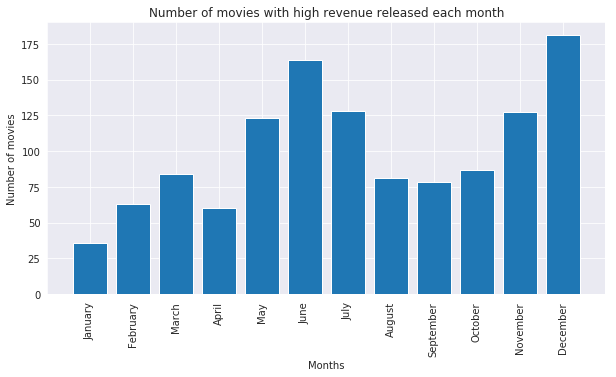

In [40]:
# compute
res = top_revenue_movies.groupby([top_revenue_movies['release_date'].map(lambda x: x.month)], as_index=True).count()['revenue']

# bar
locations = res.index
heights = res.values
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10,5)) 
plt.bar(locations, heights, tick_label=labels)
plt.title('Number of movies with high revenue released each month')
plt.xlabel('Months')
plt.ylabel('Number of movies')
plt.xticks(rotation='vertical');

We notice that movies with the highest revenue are released mainly in December and June. This could correspond to holiday periods when people have more time to go to the movies.

#### Runtime

We compute the average runtime for this sub-data set :

In [41]:
top_revenue_movies['runtime'].describe()['mean']

115.30940594059406

The movies with the highest revenue have an average runtime of 115 minutes.

#### Vote average

We compute the average vote for this sub-data set :

In [42]:
top_revenue_movies['vote_average'].describe()['mean']

6.374257425742575

The movies with the highest revenue have an average vote of 6.4.

#### Results combined

The movies with the highest revenue are mainly released in December and June, with an average budget of 71,971,828 dollars, an average runtime of 115 minutes and an average vote of 6.4.

<a id='conclusions'></a>
## Conclusions

With the first set of questions, we were able to get an overview of some of the top 10. Thus, we could see that the most used genres in the films were Drama, Comedy and Thriller, that the films with the most income were Avatar, Star Wars and Titanic and that the actors who made the most films (in this database) were Robert de Niro, Samuel L. Jackson and Bruce Willis. However, the data set may not be representative of the reality as it contains only a little bit more than 10,000 entries.

With the second set of questions, we were able to follow the evolution of some features over the years. Thus we have seen that the most recent films were generally the most popular and that budgets for films tend to increase over the years, as do revenues.

Finally, for the last question, we have tried to determine some of the characteristics of a high-revenue movies.  The movies with the highest revenue are mainly released in December and June, with an average budget of 71,971,828 dollars, an average runtime of 115 minutes and an average vote of 6.4. However, a film with these characteristics does not guarantee high revenues. There are many more variables to consider before saying so.